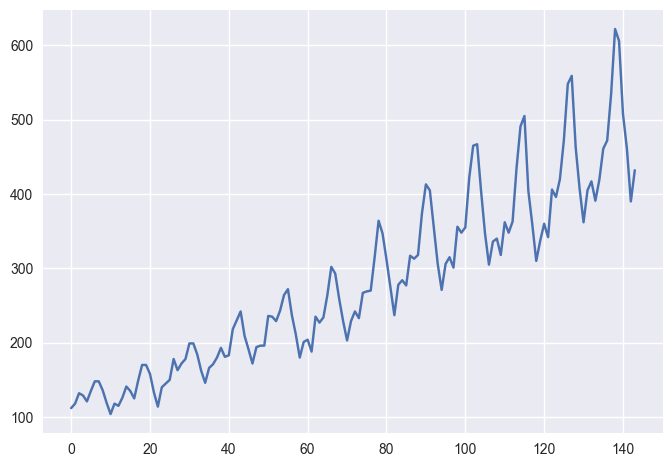

In [236]:
# LSTM for international airline passengers problem with regression framing
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


# fix random seed for reproducibility
tf.random.set_seed(7)

# load the dataset
dataframe = read_csv('./input/airline-passengers.csv', usecols=[1], engine='python')
data = dataframe.values
data = data.astype('float32')

fig, ax = plt.subplots()
ax.plot(data)

In [249]:

from libs.simple_plotter import plot_history

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)

# split into train and test sets
train_size = int(len(dataset) * 0.7)
# test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 18
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

(81, 1, 18)


Epoch 1/100


2023-01-12 12:06:03.043840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-12 12:06:03.157598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-12 12:06:03.271468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


81/81 - 3s - loss: 0.0611 - 3s/epoch - 33ms/step
Epoch 2/100
81/81 - 1s - loss: 0.0495 - 658ms/epoch - 8ms/step
Epoch 3/100
81/81 - 1s - loss: 0.0451 - 566ms/epoch - 7ms/step
Epoch 4/100
81/81 - 1s - loss: 0.0422 - 553ms/epoch - 7ms/step
Epoch 5/100
81/81 - 1s - loss: 0.0369 - 530ms/epoch - 7ms/step
Epoch 6/100
81/81 - 1s - loss: 0.0369 - 511ms/epoch - 6ms/step
Epoch 7/100
81/81 - 1s - loss: 0.0335 - 515ms/epoch - 6ms/step
Epoch 8/100
81/81 - 1s - loss: 0.0356 - 571ms/epoch - 7ms/step
Epoch 9/100
81/81 - 0s - loss: 0.0328 - 494ms/epoch - 6ms/step
Epoch 10/100
81/81 - 0s - loss: 0.0306 - 475ms/epoch - 6ms/step
Epoch 11/100
81/81 - 0s - loss: 0.0306 - 455ms/epoch - 6ms/step
Epoch 12/100
81/81 - 1s - loss: 0.0309 - 572ms/epoch - 7ms/step
Epoch 13/100
81/81 - 1s - loss: 0.0274 - 649ms/epoch - 8ms/step
Epoch 14/100
81/81 - 1s - loss: 0.0269 - 554ms/epoch - 7ms/step
Epoch 15/100
81/81 - 0s - loss: 0.0258 - 480ms/epoch - 6ms/step
Epoch 16/100
81/81 - 0s - loss: 0.0254 - 494ms/epoch - 6ms/step

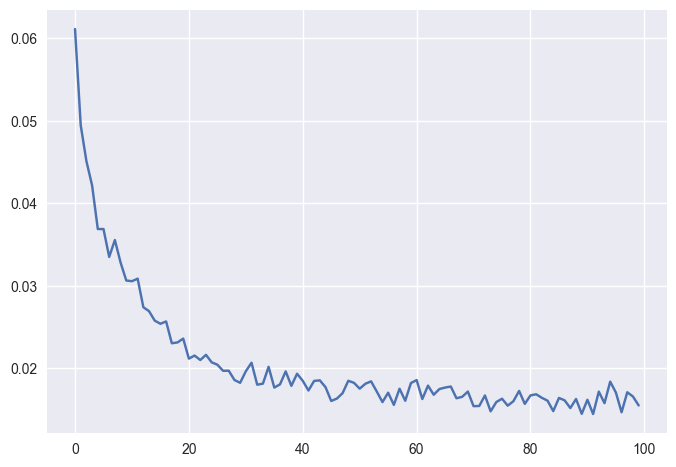

In [252]:

# create and fit the LSTM network
model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.LSTM(12, input_shape=(1, look_back), return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.LSTM(12, input_shape=(1, look_back), return_sequences=True))
model.add(tf.keras.layers.LSTM(8, input_shape=(1, look_back), return_sequences=False))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

plot_history(history)

In [253]:
from sklearn.metrics import mean_absolute_error

# make predictions
trainPredict = model.predict(trainX)
testPredictScaled = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
itrainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredictScaled)
itestY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = mean_absolute_error(itrainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(itestY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore))


2023-01-12 12:06:57.831736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-12 12:06:57.882919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 48ms/step
Train Score: 6.98 MAE
Test Score: 18.47 MAE


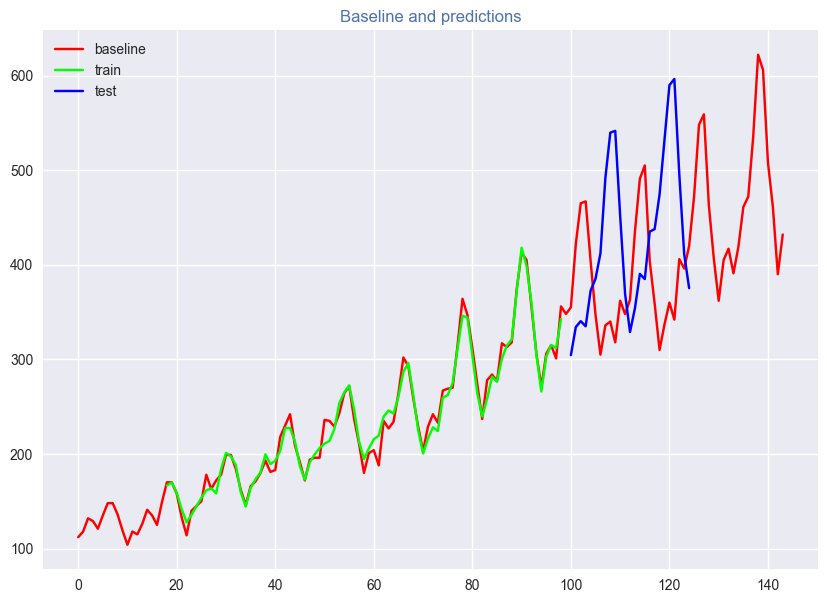

In [254]:
import matplotlib as mpl

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+look_back+1 : len(dataset)-look_back-1, :] = testPredict

# plot baseline and predictions
mpl.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title("Baseline and predictions", color='C0')
ax.plot(scaler.inverse_transform(dataset), color="#f00" , label="baseline")
ax.plot(range(len(trainPredictPlot)), trainPredictPlot, color="#0f0", label="train")
plt.plot(range(len(testPredictPlot)), testPredictPlot, color="#00f", label="test")
plt.legend()


In [255]:
import numpy as np

frame =  testX[-1:]
predictions = np.empty_like(testPredictScaled)
predictions[:, :] = np.nan
frames = 2

for f in range(frames):
    for i in range(look_back):
        new_pred = model.predict(frame)
        frame = np.roll(frame, -1)
        frame[0][0][look_back-1] = new_pred
        # [27, 29] => [27, 29, new]
        predictions = np.append(predictions, new_pred)

predictions = predictions[~np.isnan(predictions)]
print('new pred: ', predictions.shape)
print('new pred: ', predictions)


1/1 [==============================] - 0s 14ms/step
new pred:  (36,)
new pred:  [0.5237315  0.55744016 0.5763616  0.5417834  0.607306   0.6923706
 0.7421102  0.87317437 1.0194659  0.96543473 0.758425   0.5942468
 0.4209033  0.43710724 0.47205606 0.45631465 0.54315346 0.6471508
 0.74123806 0.8982086  1.0326142  0.9550796  0.7063969  0.46674246
 0.28805798 0.31311706 0.36774123 0.37957075 0.48667607 0.6163854
 0.76007664 0.9571007  1.0840967  0.9712917  0.6467487  0.31921503]


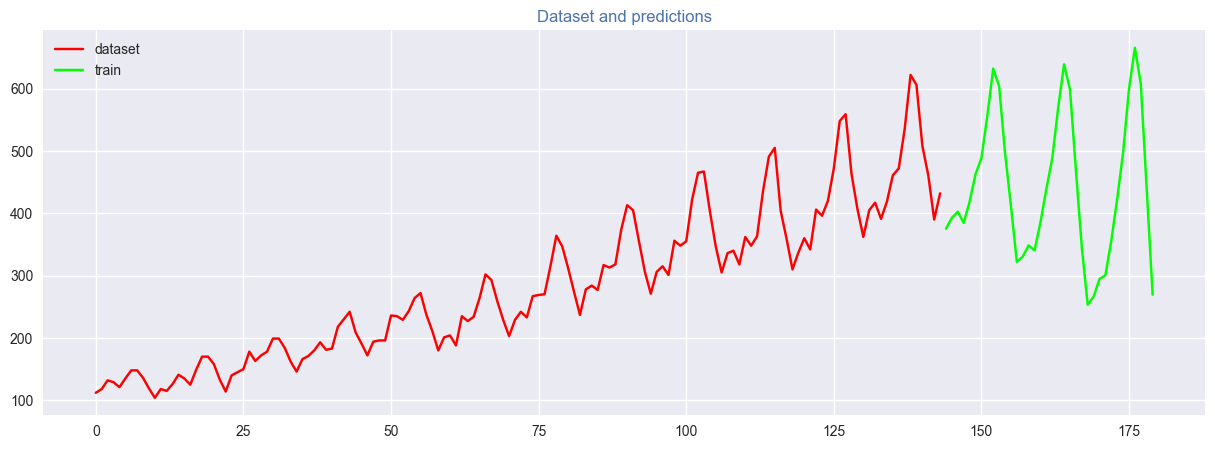

In [256]:

# shift test predictions for plotting
predictPlot = np.empty_like(data)
predictPlot[:, :] = np.nan
predictPlot = np.concatenate((predictPlot, predictions), axis=None)

# plot baseline and predictions
mpl.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title("Dataset and predictions", color='C0')
ax.plot(data, color="#f00" , label="dataset")
ax.plot(range(len(predictPlot)), scaler.inverse_transform(predictPlot.reshape(-1, 1)), color="#0f0", label="train")
plt.legend()
